In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gamma
import scipy.integrate
import pandas
from hmf import MassFunction     # The main hmf class
# TO DO: Update to most recent Planck results
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
import hmf
from hmf import functional
import winsound

In [2]:
# Path to tables of cosmic variance values
path = "../CV_Vals/"
file='hmf_extrapolate'
save=1
# Get young, blue galaxy spectrum
data = np.loadtxt("erb2010_continuum.dat")
x = data[:,0]
y = data[:,1] * x**2 / 3.e18 # Convert to correct flux values

# Constants
tot_sky = 41253. # Total degrees on the sky
masses = np.array([7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0]) # Mass bins in log(M/Msun)

# TO DO: Modify cosmic variance values from the tables such that masses <= 8 use the same cosmic variance values as 8.5
# Currently the CV values are incorrectly extrapolated to lower masses from a mass of 8.5
# The code used to calculated the CV values is called "getcv" and is included with the CV value files
#Done

trials = 10000 # Number of trials for calculating median from gamma function
mmin = 9 # Minimum halo mass for HMF
mmax = 15.5 # Maximum halo mass for HMF

In [3]:
# Function to find closest wavelength in measured galaxy spectrum compared to given value
def nearest_wavelength(x, val):
    i = (np.abs(x - val)).argmin()
    return x[i]

In [4]:
# Define a class for different survey designs
class survey:
    def __init__(self, ABmax, area, cv_file, wavelength = 0, num_pointings = 1):
        self.ABmax = ABmax # Limiting AB magnitude of the survey
        self.area = area # Survey area
        self.file = cv_file # Name of cosmic variance table file
        self.point = num_pointings # Number of independent pointings
        self.wavelength = wavelength # Center wavelength for the chosen filter

In [5]:
# Method to take one trial of a gamma distribution with a given variance and mean
def trial(sig_v, mean, trials=10000):
    var = sig_v**2*mean**2
    k = mean**2/var
    t = var/mean
    rand = np.rint(np.random.gamma(k, scale=t, size=trials))
    return rand

In [6]:
val=[-0.04418885, -0.95909967]
def lin(x,a=val[0],b=val[1]):
    return a*x+b

In [7]:
# Find mean, median number of galaxies found for a given survey design
def mean_median(survey, correction = True):
    # Get survey information
    point = survey.point
    survey_area = survey.area * point
    ABmax = survey.ABmax 
    
    # Absolute magnitude range over which to integrate
    # Range is larger than necessary to include all galaxies
    
    # Redshift values from CV calculations 
    df = pandas.read_csv(path+survey.file)
    z_vals = df["z"].values
    z_vals = z_vals[::-1]

    all_mean = []
    all_sig_v = []
    
    # Loop over z values
    for z in z_vals:
        # Get observed wavelength for a rest frame of 1600 Angstroms
        # Find closest wavelength to this value in the observed galaxy spectrum
        wl_obs = nearest_wavelength(x, 1600 * (1 + z))
        # Account for difference in observed magnitude due to difference in wavelength 
        # of the survey and the wavelength of the 
        shift=2.5 * np.log10(y[x==survey.wavelength]/y[x==wl_obs])
        ABmax_new = ABmax + shift
#         print(2.5 * np.log10(y[x==survey.wavelength]/y[x==wl_obs]))
        masses = np.array([7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])    
        mf = MassFunction(cosmo_model=cosmo,z=z,Mmin=mmin,Mmax=mmax, hmf_model="SMT")
        # Find volume of space within redshift bin
        dz = df.loc[df['z'] == z][["dz"]].values[0][0]
        vol = cosmo.comoving_volume(z + dz/2).value - cosmo.comoving_volume(z - dz/2).value
        little_h=mf.cosmo_model.h
        mass=mf.m*little_h
        dndm=mf.dndm/little_h**3 #check when to multiply
        sbf=0.018
        stellar_mass=mass*sbf
        norm=lin(z)
        # Extrapolation of M*-MUV relation from Song 2016 to z = z
        M_vals=-2.*(-norm + np.log10(stellar_mass))
        m = np.array(M_vals + cosmo.distmod(z).value)+shift
        u_lim = max(m)
        l_lim = min(m)
        u_lim = min(u_lim, ABmax_new) # Compare dimmest object to telescope limit

        index= m<=u_lim
        stellar_mass=stellar_mass[index]
        cum_n=hmf.integrate_hmf.hmf_integral_gtm(stellar_mass, dndm[index]+1e-321)
        means=[]
        sigs=[]
        for i in range(len(masses)):
            index=np.abs(stellar_mass - 10**masses[i]).argmin()
#             print(index)
            integral=cum_n[index]
            means.append(integral * vol * survey_area / tot_sky)
            
            # Get cosmic variance value for this z value and mass bin
            # CV values calculated as in Moster et al. 2010
            sig_v = float(df.loc[df['z'] == z][[str(masses[i])]].values[0][0]) / np.sqrt(int(point))
            sigs.append(sig_v)

        # Append mean and variance values of all masses for this redshift 
        all_mean.append(means)
        all_sig_v.append(sigs)
        
    all_tot_mean = []
    all_med = []
    
    # Loop over all z values (high to low)
    for i in range(len(z_vals)):
        tot_mean = 0
        tot_trials = np.zeros(trials)
        # Find cumulative mean and median number of observed galaxies up to z
        for j in range(i+1):
            means = all_mean[j]
            sigs = all_sig_v[j]
            # Run trials of gamma distribution to find median
            for k in range(len(masses)):
                if means[k] != 0:
                    one_trial = trial(sigs[k], means[k])
                    tot_trials = tot_trials + one_trial
                    tot_mean += means[k]
        all_tot_mean.append(tot_mean)
        med = np.median(tot_trials)
        all_med.append(med)
    return np.array(all_tot_mean), np.array(all_med), z_vals

# Plots

In [8]:
# Survey design matching the idealized survey from Mashian et al. 2015

mashian = survey(31.5, 200./3600, "cv_mashian.csv", nearest_wavelength(x,14873.4))
mean_mashian, med_mashian, z_vals_mashian = mean_median(mashian)
z_vals=z_vals_mashian

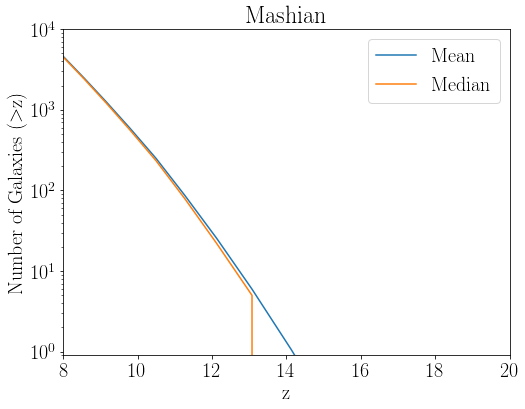

In [9]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_mashian, mean_mashian, label = "Mean")
plt.plot(z_vals_mashian, med_mashian, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)") #is this really z or above, i think it is just z
plt.yscale("Log")

plt.legend()

plt.ylim(0.9, 1e4)
# plt.xlim(8,max(z_vals)+1)
plt.xlim(8,20)
plt.title("Mashian")

if save==1:
    plt.savefig("figs/"+file+"/mashian.pdf")
winsound.Beep(400,300)

In [10]:
z_vals[np.abs(1.1-mean_mashian).argmin()], z_vals[np.abs(4-med_mashian).argmin()]

(14.1315, 13.0755)

In [11]:
# Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)

deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
mean_deep, med_deep, z_vals_deep = mean_median(deep)

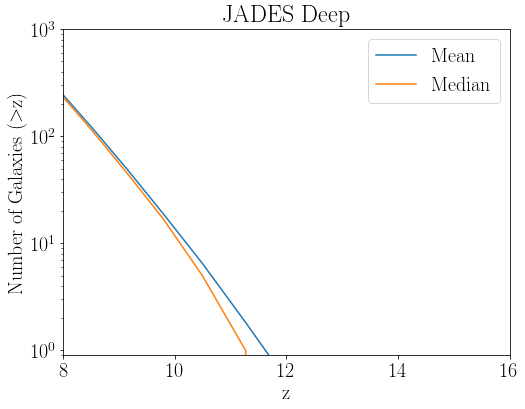

In [12]:
z_vals=z_vals_deep
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_deep, mean_deep, label = "Mean")
plt.plot(z_vals_deep, med_deep, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.9, 1e3)
plt.xlim(8,16)


plt.title("JADES Deep")
if save==1:
    plt.savefig("figs/"+file+"/jadesdeep.pdf")

In [13]:
z_vals[np.abs(1.1-mean_deep).argmin()], z_vals[np.abs(1.1-med_deep).argmin()]

(12.126, 11.2695)

In [14]:
# Survey design matching the JADES Wide survey from Williams et al. 2018 (pg. 36)

wide = survey(29.8, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
mean_wide, med_wide, z_vals_wide = mean_median(wide)

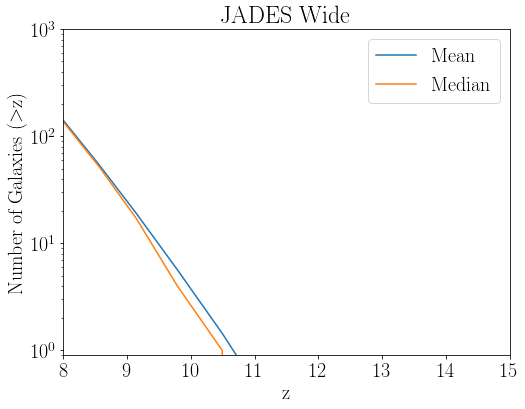

In [15]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_wide, mean_wide, label = "Mean")
plt.plot(z_vals_wide, med_wide, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.9, 1e3)
plt.xlim(8,15)

plt.title("JADES Wide")

if save==1:
    plt.savefig("figs/"+file+"/jadeswide.pdf")

In [16]:
z_vals[np.abs(1.1-mean_wide).argmin()], z_vals[np.abs(2-med_wide).argmin()]

(10.4945, 10.4945)

In [17]:
# Survey design assuming 35 parallel pointings of JWST
# Uses limiting magnitude from JADES Deep, area of one JWST pointing

parallel_35 = survey(30.7, 4.84/3600*2, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 20)
mean_35, med_35, z_vals_35 = mean_median(parallel_35)

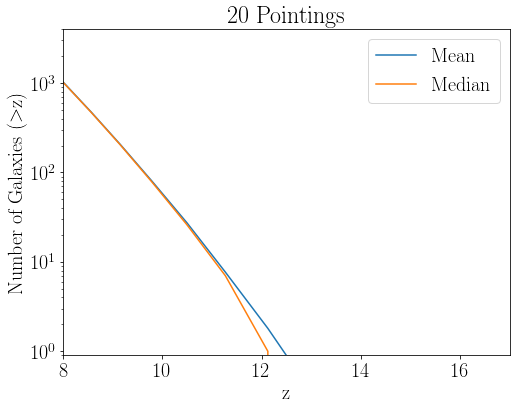

In [18]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_35, mean_35, label = "Mean")
plt.plot(z_vals_35, med_35, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.9, 4e3)
plt.xlim(8,17)

plt.title("20 Pointings")

# Survey design assuming 35 parallel pointings of JWST#plt.savefig("35.pdf")
if save==1:
    plt.savefig("figs/"+file+"/16.pdf")

In [19]:
z_vals[np.abs(1.1-mean_35).argmin()], z_vals[np.abs(5-med_35).argmin()]

(12.126, 11.2695)

In [20]:
# Survey design assuming 10 parallel pointings of JWST

parallel_10 = survey(30.7, 4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 10)
mean_10, med_10, z_vals_10 = mean_median(parallel_10)

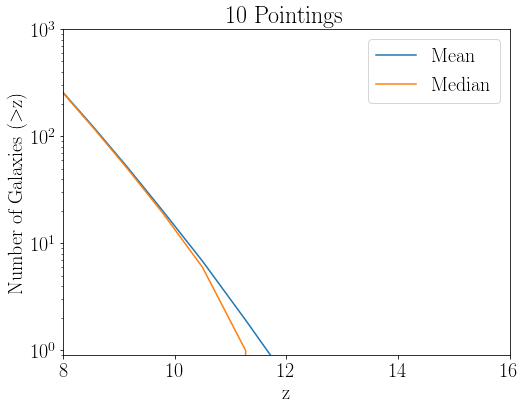

In [21]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_10, mean_10, label = "Mean")
plt.plot(z_vals_10, med_10, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.9, 1e3)
plt.xlim(8,16)

plt.title("10 Pointings")

if save==1:
    plt.savefig("figs/"+file+"/10.pdf")

In [22]:
z_vals[np.abs(1.1-mean_10).argmin()], z_vals[np.abs(2-med_10).argmin()]

(12.126, 11.2695)

In [23]:
# Survey design assuming 200 parallel pointings of JWST

parallel_200 = survey(30.7, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 100)
mean_200, med_200, z_vals_200 = mean_median(parallel_200)

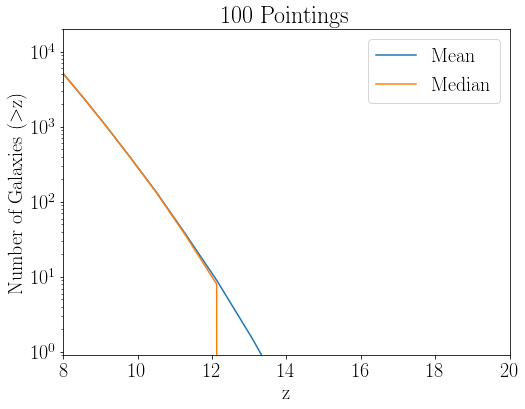

In [24]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_200, mean_200, label = "Mean")
plt.plot(z_vals_200, med_200, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.9, 2e4)
plt.xlim(8,20)

plt.title("100 Pointings")

if save==1:
    plt.savefig("figs/"+file+"/100.pdf")

In [25]:
z_vals[np.abs(1.1-mean_200).argmin()], z_vals[np.abs(2-med_200).argmin()]

(13.0755, 23.9445)

In [26]:
# Survey design assuming 2000 parallel pointings of JWST

parallel_2000 = survey(30.7, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1000)
mean_2000, med_2000, z_vals_2000 = mean_median(parallel_2000)

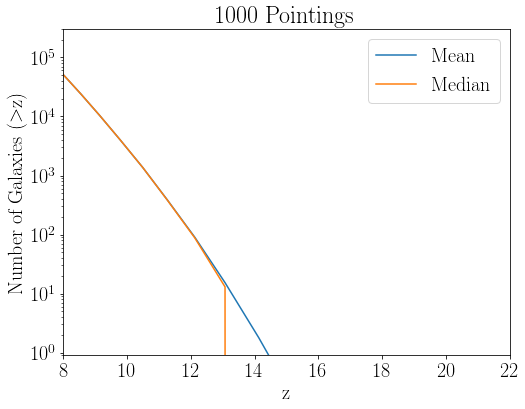

In [27]:
fig = plt.figure(figsize = (8, 6))
ax = plt.axes()
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_2000, mean_2000, label = "Mean")
plt.plot(z_vals_2000, med_2000, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()
plt.ylim(0.9, 3e5)
plt.xlim(8, 22)

plt.title("1000 Pointings")
if save==1:
    plt.savefig("figs/"+file+"/1000.pdf")

In [28]:
z_vals[np.abs(1.1-mean_2000).argmin()], z_vals[np.abs(1.1-med_2000).argmin()]

(14.1315, 23.9445)

In [29]:
# Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
# Assumes this is over one JWST pointing

lensing_2 = survey(30.7 + 2, 2*4.84/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)

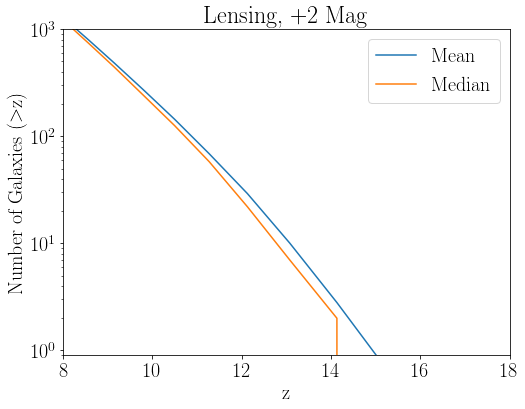

In [30]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_lens, mean_lens, label = "Mean")
plt.plot(z_vals_lens, med_lens, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.9, 1e3)
plt.xlim(8, 18)

plt.title("Lensing, +2 Mag")

if save==1:
    plt.savefig("figs/"+file+"/lensing.pdf")

In [31]:
z_vals[np.abs(1.1-mean_lens).argmin()], z_vals[np.abs(1.1-med_lens).argmin()]

(15.311, 14.1315)